<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_01_15_spectral_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Clustering

## YouTube
I explained this notebook in a [YouTube video](https://youtu.be/k7M1TMYac-Y).

## References:
```bibtex
@inproceedings{NIPS2001_801272ee,
  author    = {Ng, Andrew and Jordan, Michael and Weiss, Yair},
  booktitle = {Advances in Neural Information Processing Systems},
  title     = {On Spectral Clustering: Analysis and an algorithm},
  year      = {2001}
}
```

```bibtex
@misc{vonluxburg2007tutorial,
  title         = {A Tutorial on Spectral Clustering},
  author        = {Ulrike von Luxburg},
  year          = {2007},
  eprint        = {0711.0189},
  archivePrefix = {arXiv},
  primaryClass  = {cs.DS}
}
```

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm

# scikit-learn
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
random_seed = 42
plt.style.use('dark_background')

## Prepare dataset

In [ ]:
X, y = make_blobs(n_samples=200, n_features=2, centers=1, cluster_std=0.15, random_state=random_seed)
# center at the origin
X = X - np.mean(X, axis=0)

X1, y1 = make_circles(n_samples=[600, 200], noise=0.04, factor=0.5, random_state=random_seed)
# add 1 to (make_circles) labels to account for (make_blobs) label
y1 = y1 + 1
# increase the radius
X1 = X1*3

X = np.concatenate((X, X1), axis=0)
y = np.concatenate((y, y1), axis=0)

In [ ]:
plot_colors = cm.tab10.colors
y_colors = np.array(plot_colors)[y]

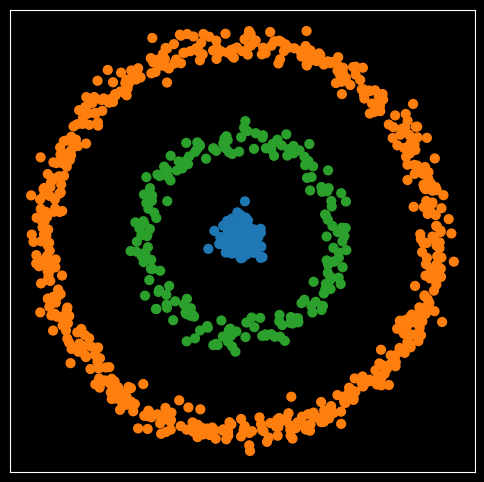

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], marker='o', s=40, color=y_colors)

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
plt.show()
# plt.axis('off')
# plt.savefig('plot.png', bbox_inches='tight', dpi=600, transparent=True)

## Adjacency matrix $A$
An $n \times n$ matrix, where each element represents the disance between a pair of samples. This is th formula to construct the adjacency matrix $A$:

$A_{ij}=exp(\frac{-\big\|s_i-s_j\big\|^2}{2{\sigma}^2})$

In [ ]:
# An n by n matrix, where each element represents the similarity between a pair of samples
sigma = 1
A = -1 * np.square(X[:, None, :] - X[None, :, :]).sum(axis=-1)
A = np.exp(A / (2* sigma**2))
np.fill_diagonal(A, 0)

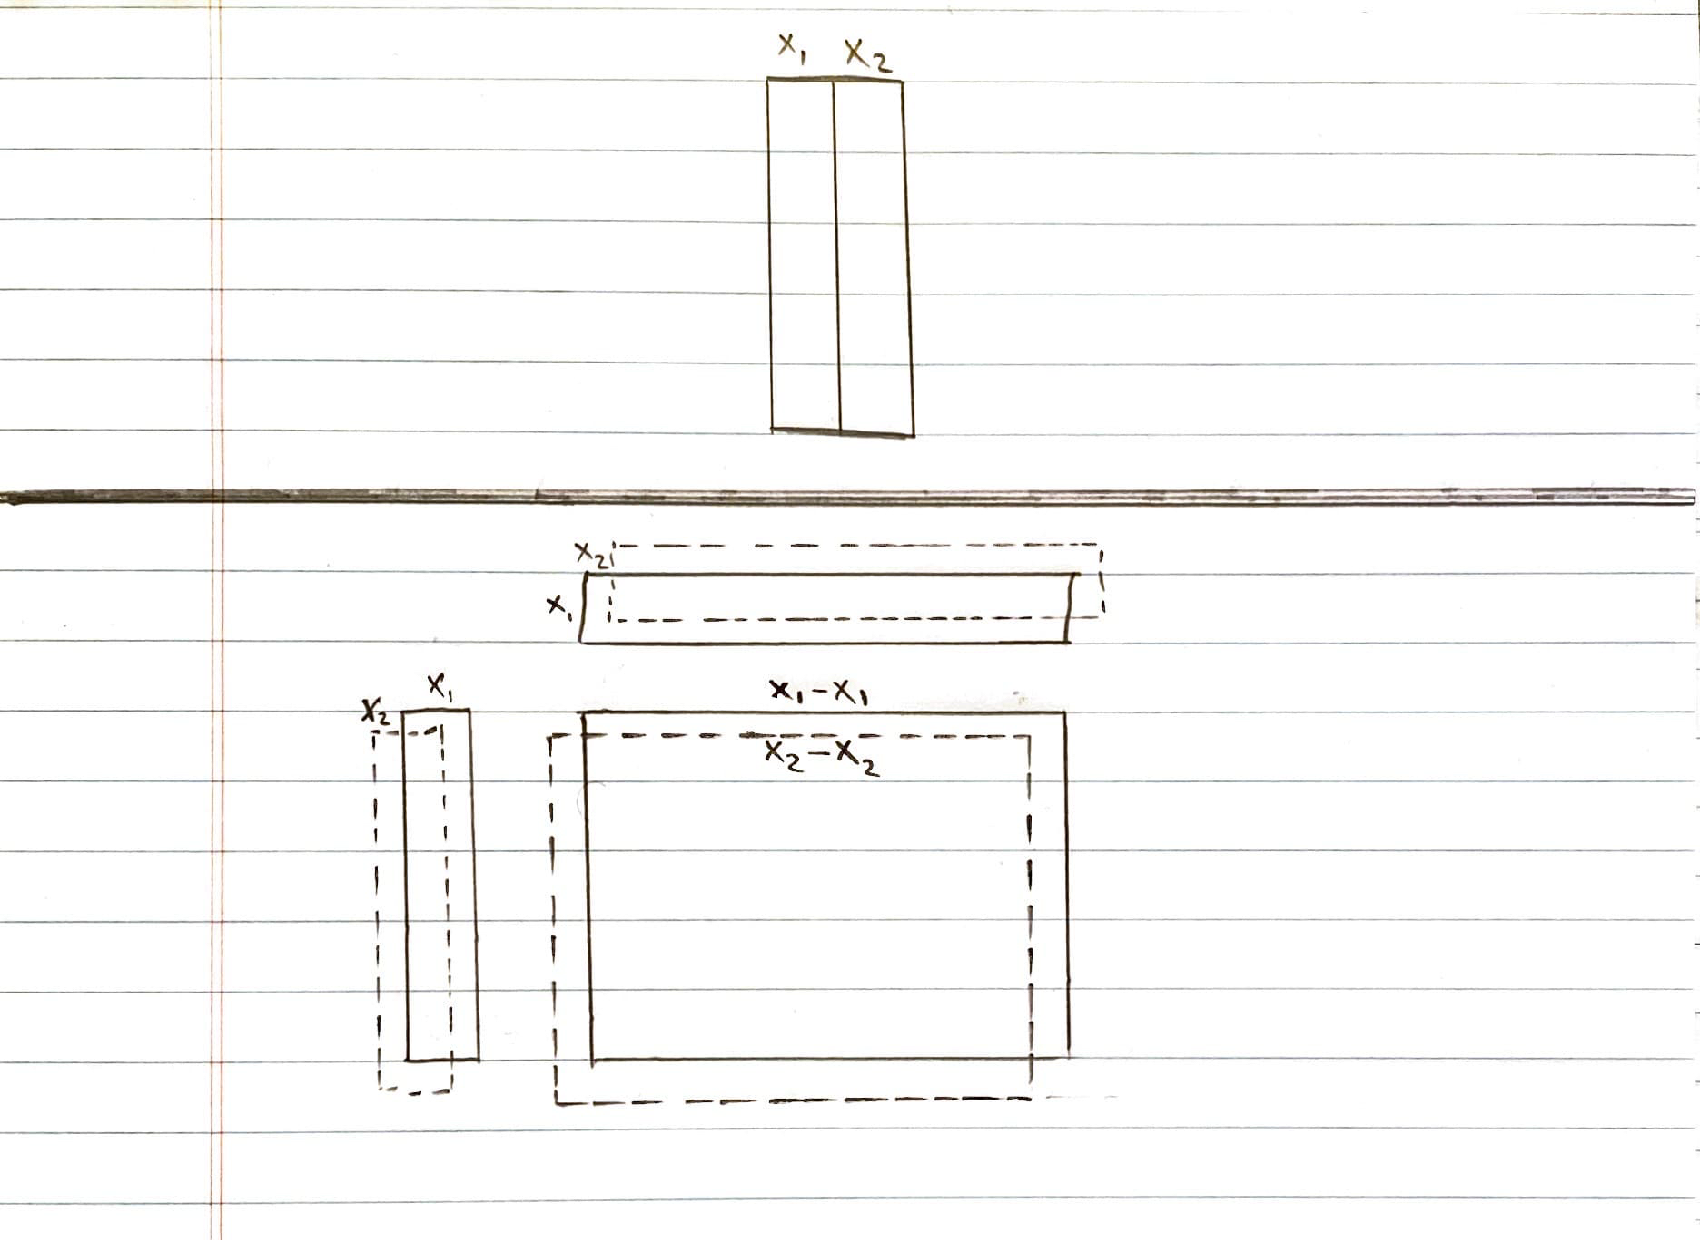

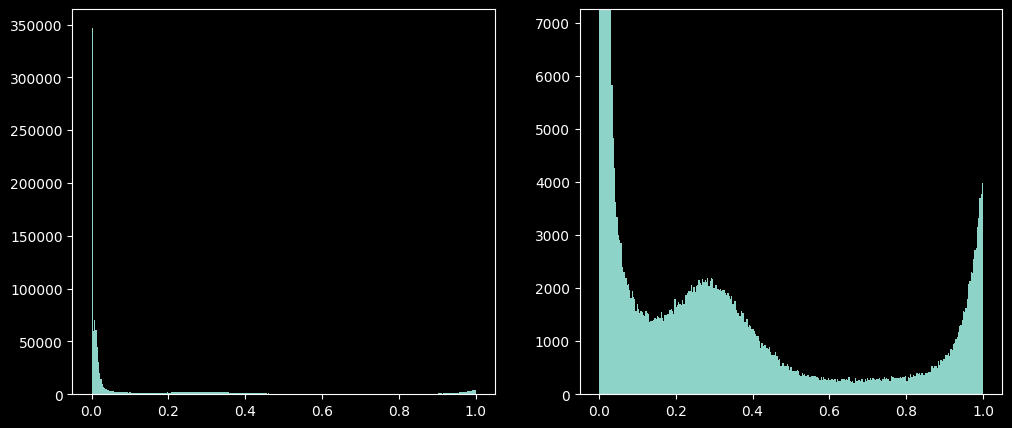

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_values, _, _ = ax1.hist(A.flatten(), bins='auto')

# limit the y-axis to the value of the 10th bin
ax2.hist(A.flatten(), bins='auto')
ax2.set_ylim([0, bin_values[9]])

plt.show()

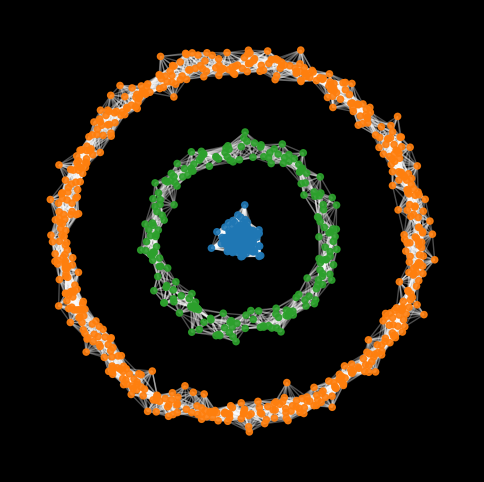

In [ ]:
A1 = np.copy(A)
A1[A1 < 0.9] = 0
G = nx.from_numpy_array(A1)

plt.figure(figsize=(6,6))
plt.axis('off')
nx.draw_networkx_nodes(G, pos=X, node_size=20, node_color=y_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos=X, edge_color="white", alpha=0.3)
plt.show()
# plt.savefig('plot-G.png', bbox_inches='tight', dpi=600, transparent=True)

## Graph Laplacian

In [ ]:
# identity matrix
I = np.zeros_like(A)
np.fill_diagonal(I, 1)

# degree matrix
D = np.zeros_like(A)
np.fill_diagonal(D, np.sum(A,axis=1))
D_inv_sqrt = np.linalg.inv(np.sqrt(D))

L = I - np.dot(D_inv_sqrt, A).dot(D_inv_sqrt)

## Eigenvalues and Eigenvectors

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(L)
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

# Order the eigenvalues in an increasing order
ind = np.argsort(eigenvalues, axis=0)
eigenvalues_sorted = np.take_along_axis(eigenvalues, ind, axis=0)

# Order the eigenvectors based on the magnitude of their corresponding eigenvalues
eigenvectors_sorted = eigenvectors.take(ind, axis=1)

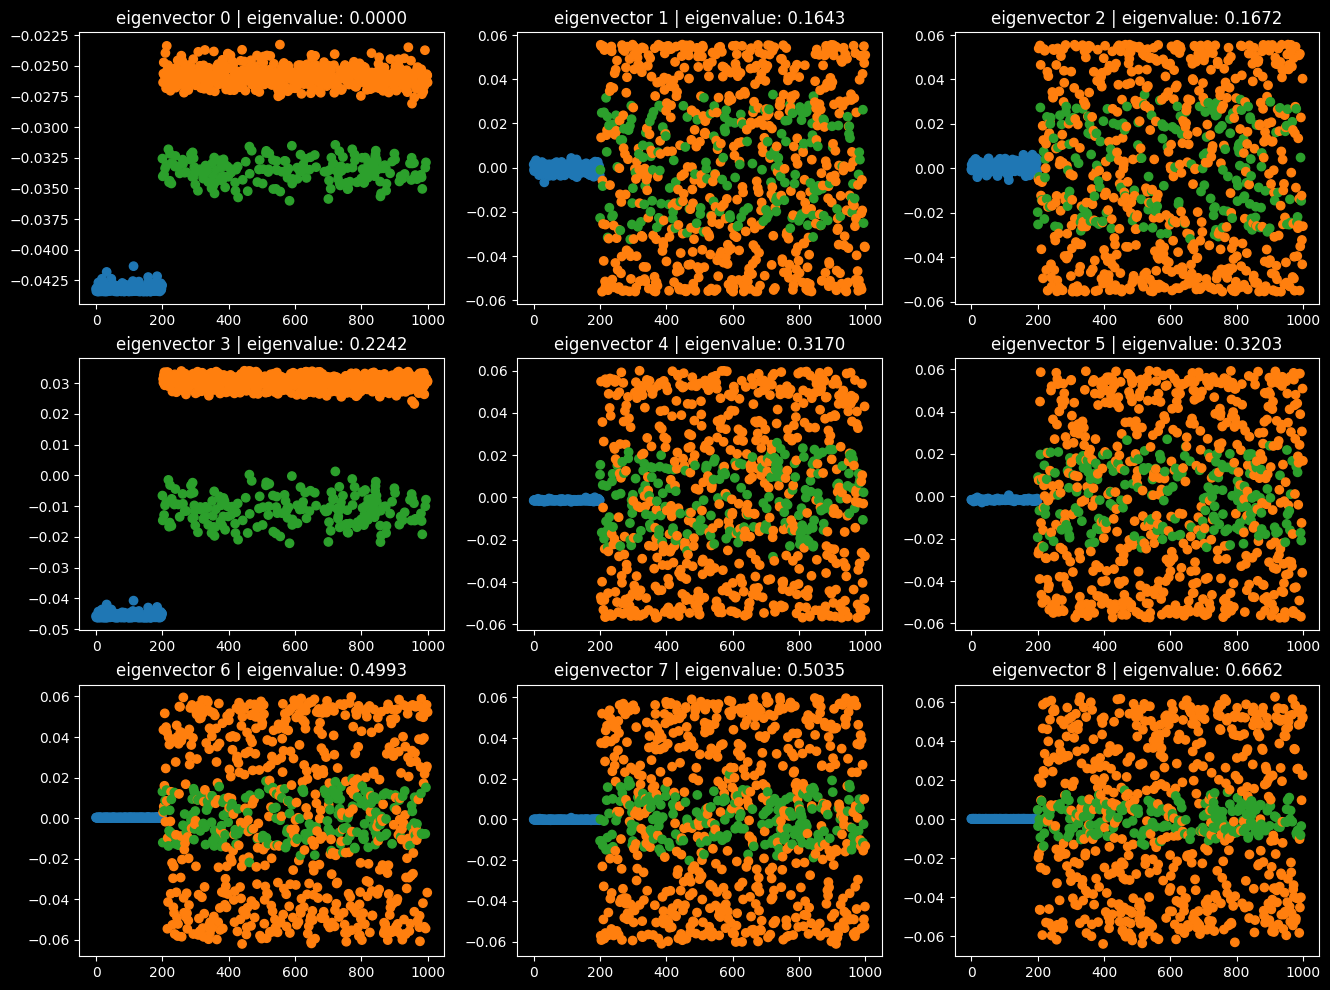

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
eigen_v_x = np.linspace(0, eigenvectors_sorted.shape[0], eigenvectors_sorted.shape[0])

for j, ax in enumerate(fig.axes):
  eigen_v_y = eigenvectors_sorted[:,j]
  ax.scatter(eigen_v_x, eigen_v_y, marker='o', color=y_colors)
  ax.set_title(f'eigenvector {j} | eigenvalue: {eigenvalues_sorted[j]:.4f}')

plt.show()

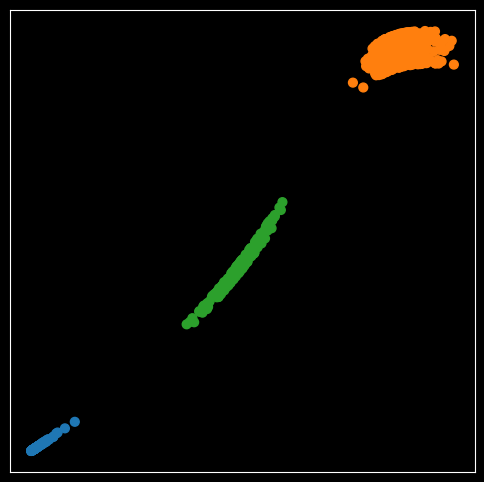

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(eigenvectors_sorted[:,0], eigenvectors_sorted[:,3], marker='o', s=40, color=y_colors)

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
plt.show()

In [ ]:
X_transformed = eigenvectors_sorted[:,[0,3]]

scaler = StandardScaler()
scaler.fit(X_transformed)
X_transformed_scaled = scaler.transform(X_transformed)


kmeans = KMeans(n_clusters = 3, random_state = random_seed, n_init='auto')
kmeans.fit(X_transformed_scaled)

KMeans(n_clusters=3, n_init='auto', random_state=42)

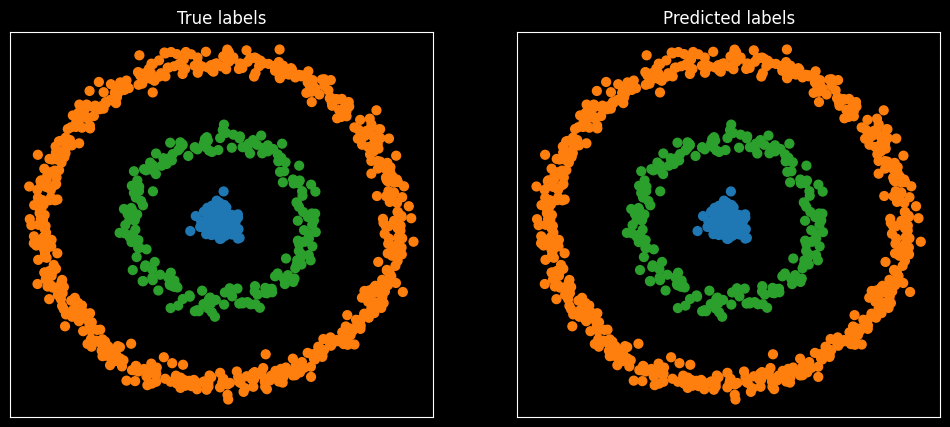

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(X[:,0], X[:,1], marker='o', s=40, color=y_colors)
ax1.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax1.set(xlabel=None, ylabel=None)
ax1.set_title('True labels')

ax2.scatter(X[:,0], X[:,1], marker='o', s=40, color=np.array(plot_colors)[kmeans.labels_])
ax2.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax2.set(xlabel=None, ylabel=None)
ax2.set_title('Predicted labels')

plt.show()